In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd

## Quick Links:

1. https://atlas.brain-map.org/atlas?atlas=1&plate=100960073#atlas=1&plate=100960073&resolution=8.38&x=7135.778015136719&y=1986.4626932144165&zoom=-2&structure=385 - this allows you to see the areas of the mapped mouse brain - currently focused on the VISp area
2. https://sci-hub.se/https://www.nature.com/articles/nmeth.1854 - this explains the serial two-photon tomography which from my rudimentary reductionist pov just means that hey, now we can image cells with dna or something (warning: generated by me).

## Steps Taken

Since this is an exploratory analysis of the data, it is a bit haphazard.

1. Data has been downloaded from this link (https://map-my-sections-802451596237-us-west-2.s3.us-west-2.amazonaws.com/index.html)
2. Specifically I picked an entry inside stpt ("1267695363") that has some quantitative analysis data entries in the Excel MapMySections_EntrantData.xlsx - so the quantification.zip file was downloaded (https://map-my-sections-802451596237-us-west-2.s3.us-west-2.amazonaws.com/index.html#stpt-image-data/1267695363/) and unzipped and placed for analysis below
3. I plot the green and red nii with the annotation boundary overlay (most of this code is inspired by https://github.com/AllenInstitute/MapMySections/blob/main/ccf_and_registered_stpt_tutorial.ipynb)
    > (Generated from grok3 - because my bio is weak) Why Red and Green Exist in Mouse Data:
    Fluorescence Imaging and Multiple Channels:
    In fluorescence microscopy, different fluorescent markers (fluorophores) are used to label specific cells, proteins, or structures in the mouse brain. These markers emit light at distinct wavelengths when excited by a laser.
    The "red" and "green" in your file names likely correspond to two separate fluorescence channels, each capturing emissions from different fluorophores:
    Green channel: Often associated with fluorophores like GFP (Green Fluorescent Protein) or FITC, which emit light in the green spectrum (~ 500–570 nm).
    Red channel: Often associated with fluorophores like tdTomato, mCherry, or Texas Red, which emit light in the red spectrum (~ 580–650 nm).
    These channels allow researchers to visualize and distinguish different biological components simultaneously in the same sample.
    Applications in Mouse Brain Studies:
    Cell Type Labeling: Different cell types or populations (e.g., excitatory vs. inhibitory neurons) may be labeled with green or red fluorophores to study their distribution or connectivity.
    Functional Imaging: Fluorescent indicators like GCaMP (green) might be used to monitor calcium activity (neural activity), while a red fluorophore could label a reference structure or another cell type.
    Gene Expression: Transgenic mice expressing fluorescent proteins under specific promoters allow researchers to map gene expression or protein localization.
    Anatomical Reference: One channel (e.g., red) might label a structural marker (e.g., blood vessels or a ubiquitous cell marker), while the green channel highlights a specific feature of interest.
4. Plotted the red-green channels together.
5. Plotted just green with a cmap.
6. Plotted just green with a cmap and points in the graph where the intensity was above the 1/8th of the total intensity (I will have to find how to find what this number needs to be).
7. Then I was interested in parcels within the annotation, so that is plotted.
8. Because at first the challenge only wants us to deal with the VISp region I look into which parcels correspond to it using this file: reference/parcellation_to_parcellation_term_membership_acronym.csv and what helps to see if we are correct is https://atlas.brain-map.org/atlas?atlas=1&plate=100960073#atlas=1&plate=100960073&resolution=8.38&x=8949.696655273438&y=2843.13125705719&zoom=-3&structure=385 (gsearch query: allen mouse brain atlas visp brain).
9. Now we have like rough understanding on parcels, and dealing with stpt files.

In [2]:
reference_path = os.path.join('reference')

file = os.path.join(reference_path, 'average_template_25.nii.gz')
average_template_image = sitk.ReadImage(file)
average_template_array = sitk.GetArrayViewFromImage(average_template_image)

file = os.path.join(reference_path, 'annotation_25.nii.gz')
annotation_image = sitk.ReadImage(file)
annotation_array = sitk.GetArrayViewFromImage(annotation_image)
annotation_index = np.where( annotation_array > 0 )
annotation = annotation_array[annotation_index]
parcellation_index = np.unique( annotation_array[annotation_index] )

file = os.path.join(reference_path, 'annotation_boundary_25.nii.gz')
annotation_boundary_image = sitk.ReadImage(file)
annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

def plot_section(slice, cmap = plt.cm.Greys_r, fig_width = 8, fig_height = 8):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.imshow(slice, cmap=cmap)
    else :
        plt.imshow(slice)
    plt.axis("off")
    return fig, ax

In [3]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def load_user_data(user_number="1267695363"):
    complete_path = user_number + ""
    
    # Load green intensity image
    green_intensity_path = os.path.join(complete_path, "resampled_green_25.nii.gz")
    green_intensity_image = sitk.ReadImage(green_intensity_path)
    green_intensity_array = sitk.GetArrayViewFromImage(green_intensity_image)
    
    # Load red intensity image
    red_intensity_path = os.path.join(complete_path, "resampled_red_25.nii.gz")
    red_intensity_image = sitk.ReadImage(red_intensity_path)
    red_intensity_array = sitk.GetArrayViewFromImage(red_intensity_image)

    zindex = 295
    
    # Plot 1: Normal green intensity slice
    zslice_green = np.transpose(green_intensity_array[:, :, zindex])
    fig1, ax1 = plot_section(zslice_green)
    ax1.set_title(f"{user_number} green_nii_25")
    plt.show()
    
    # Plot 2: Green intensity with boundary overlay
    value_green = np.max(zslice_green) * 0.6
    zbound = np.transpose(annotation_boundary_array[:, :, zindex])
    zmerged_green = np.copy(zslice_green)
    sindx = np.where(zbound > 0)
    zmerged_green[sindx] = value_green
    fig2, ax2 = plot_section(zmerged_green)
    ax2.set_title(f"{user_number} green with boundary overlay")
    plt.show()

    # Plot 1: Normal green intensity slice
    zslice_red = np.transpose(red_intensity_array[:, :, zindex])
    fig3, ax3 = plot_section(zslice_red)
    ax3.set_title(f"{user_number} red_nii_25")
    plt.show()
    
    # Plot 3: Red intensity with boundary overlay
    zslice_red = np.transpose(red_intensity_array[:, :, zindex])
    value_red = np.max(zslice_red) * 0.6
    zmerged_red = np.copy(zslice_red)
    zmerged_red[sindx] = value_red
    fig4, ax4 = plot_section(zmerged_red)
    ax4.set_title(f"{user_number} red with boundary overlay")
    plt.show()

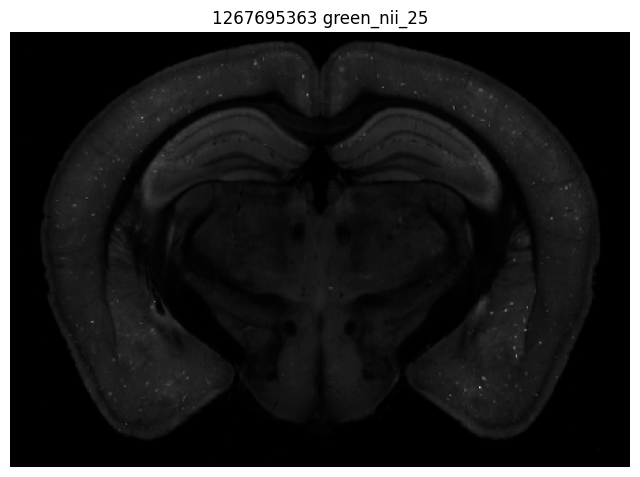

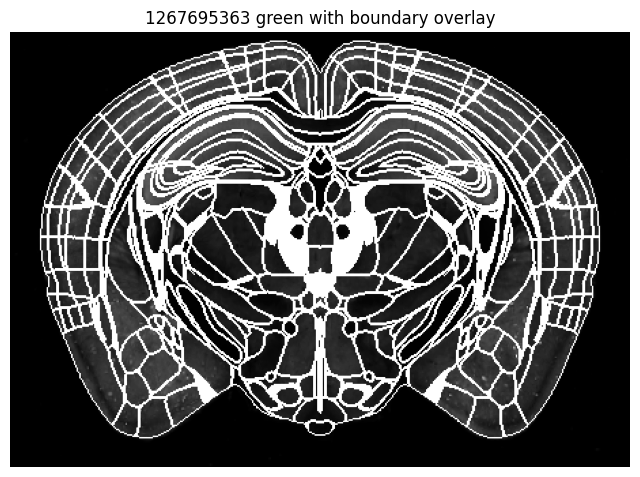

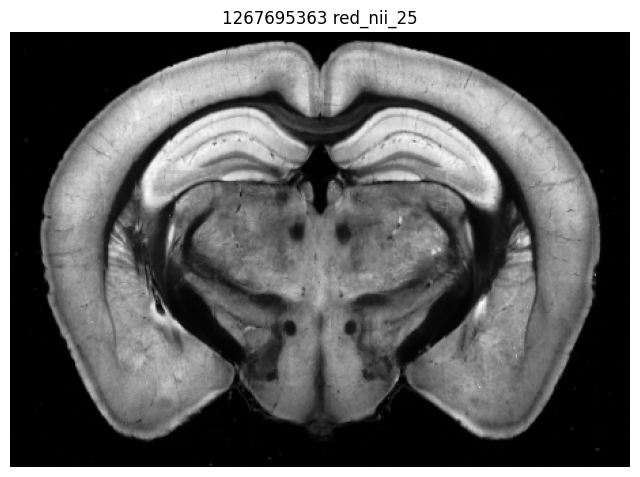

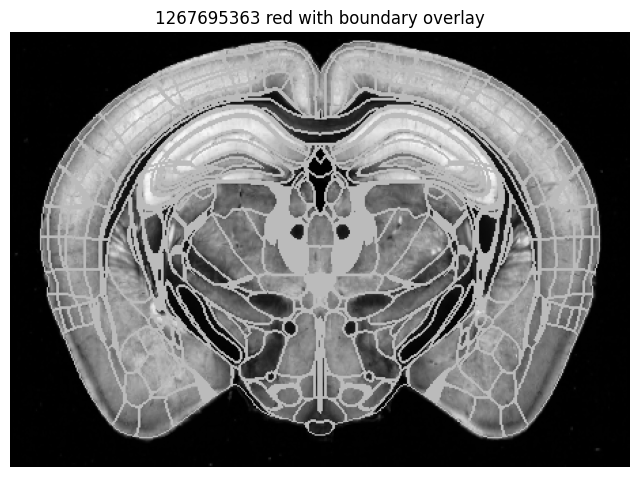

In [4]:
load_user_data()

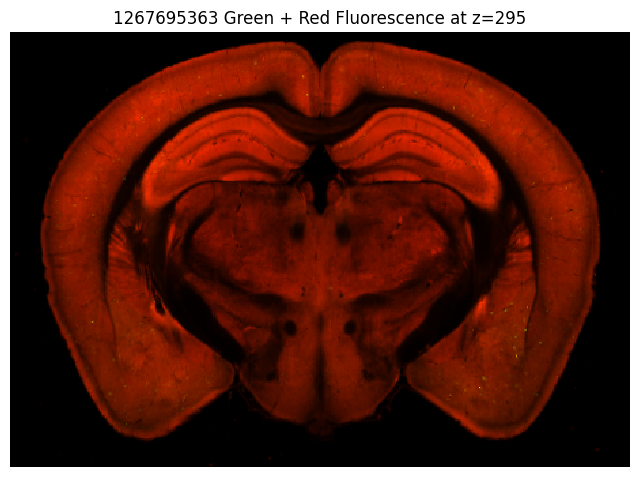

In [5]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def load_user_data(user_number="1267695363", zindex=295):
    complete_path = user_number  # Adjust if needed
    
    # Load green intensity image
    green_intensity_path = os.path.join(complete_path, "resampled_green_25.nii.gz")
    green_intensity_image = sitk.ReadImage(green_intensity_path)
    green_intensity_array = sitk.GetArrayViewFromImage(green_intensity_image)
    
    # Load red intensity image
    red_intensity_path = os.path.join(complete_path, "resampled_red_25.nii.gz")
    red_intensity_image = sitk.ReadImage(red_intensity_path)
    red_intensity_array = sitk.GetArrayViewFromImage(red_intensity_image)
    
    # Create composite RGB image
    zslice_green = np.transpose(green_intensity_array[:, :, zindex])
    zslice_red = np.transpose(red_intensity_array[:, :, zindex])
    
    # Normalize intensities to [0, 1]
    zslice_green = (zslice_green - zslice_green.min()) / (zslice_green.max() - zslice_green.min() + 1e-6)
    zslice_red = (zslice_red - zslice_red.min()) / (zslice_red.max() - zslice_red.min() + 1e-6)
    
    # Create RGB image
    rgb_image = np.zeros((zslice_green.shape[0], zslice_green.shape[1], 3))
    rgb_image[:, :, 0] = zslice_red  # Red channel
    rgb_image[:, :, 1] = zslice_green  # Green channel
    
    # Display composite image
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(rgb_image, interpolation='none')
    ax.set_title(f"{user_number} Green + Red Fluorescence at z={zindex}")
    ax.axis('off')
    plt.show()

load_user_data()

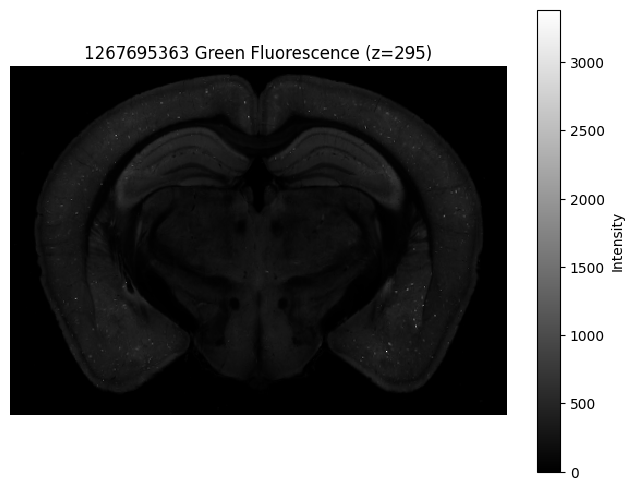

In [6]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def plot_section(data, cmap='gray', title=""):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(data, cmap=cmap, interpolation='none')
    ax.axis('off')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Intensity')
    return fig, ax

def load_user_data(user_number="1267695363", zindex=295):
    complete_path = user_number  # Simplified from user_number + ""
    
    # Load green intensity image
    green_intensity_path = os.path.join(complete_path, "resampled_green_25.nii.gz")
    green_intensity_image = sitk.ReadImage(green_intensity_path)
    green_intensity_array = sitk.GetArrayViewFromImage(green_intensity_image)
    
    # Plot green intensity slice with colorbar
    zslice_green = np.transpose(green_intensity_array[:, :, zindex])
    fig, ax = plot_section(zslice_green, title=f"{user_number} Green Fluorescence (z={zindex})")
    plt.show()

load_user_data()

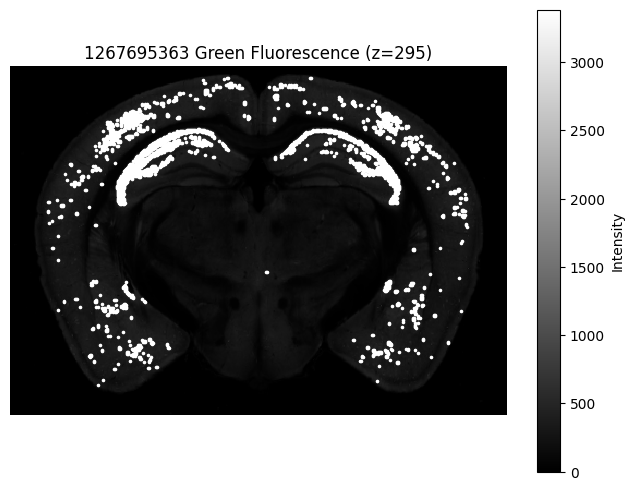

In [7]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def plot_section(data, cmap='gray', title=""):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(data, cmap=cmap, interpolation='none')
    
    # Calculate threshold (half of maximum intensity)
    threshold = data.max() / 7
    # Find pixels above threshold
    y, x = np.where(data > threshold)
    # Plot white dots at those locations
    ax.scatter(x, y, c='white', s=10, marker='.')
    
    ax.axis('off')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Intensity')
    return fig, ax

def load_user_data(user_number="1267695363", zindex=295):
    complete_path = user_number
    
    # Load green intensity image
    green_intensity_path = os.path.join(complete_path, "resampled_green_25.nii.gz")
    green_intensity_image = sitk.ReadImage(green_intensity_path)
    green_intensity_array = sitk.GetArrayViewFromImage(green_intensity_image)
    
    # Plot green intensity slice with white dots and colorbar
    zslice_green = np.transpose(green_intensity_array[:, :, zindex])
    fig, ax = plot_section(zslice_green, title=f"{user_number} Green Fluorescence (z={zindex})")
    plt.show()

load_user_data()

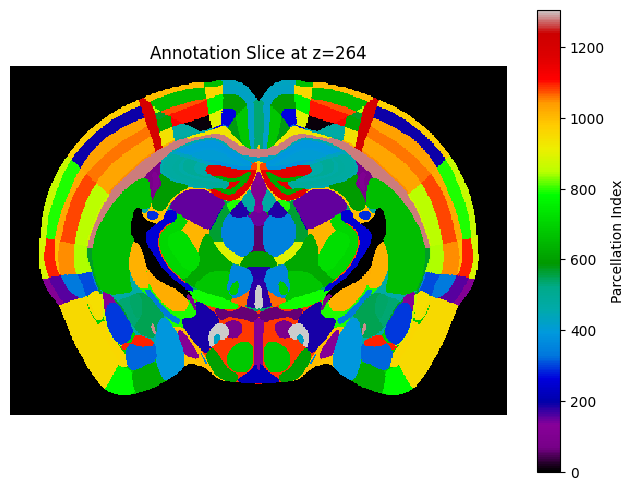

In [8]:
zindex = annotation_array.shape[2] // 2  # Middle slice
zslice = np.transpose(annotation_array[:, :, zindex])

plt.figure(figsize=(8, 6))
plt.imshow(zslice, cmap='nipy_spectral', interpolation='none')
plt.colorbar(label='Parcellation Index')
plt.title(f'Annotation Slice at z={zindex}')
plt.axis('off')
plt.show()

In [9]:
df = pd.read_csv("reference/parcellation_to_parcellation_term_membership_acronym.csv")
visp_rows = df[
    (df['substructure'].str.contains('visp', case=False, na=False)) &  # Contains "visp"
    (~df['substructure'].str.contains('m', case=False, na=False)) &    # Does not contain "m"
    (~df['substructure'].str.contains('l', case=False, na=False)) &    # Does not contain "l"
    (~df['substructure'].str.contains('or', case=False, na=False)) &    # Does not contain "or"
    (df['substructure'].notna()) & (df['substructure'] != '')          # Not NaN or empty
]

print(visp_rows)

visp_rows["parcellation_index"].tolist()

     parcellation_index  organ category   division structure substructure
17                   29  brain     grey  Isocortex      VISp       VISp6a
162                 295  brain     grey  Isocortex      VISp       VISp6b
300                 583  brain     grey  Isocortex      VISp        VISp1
375                 711  brain     grey  Isocortex      VISp        VISp4
400                 768  brain     grey  Isocortex      VISp        VISp5
425                 811  brain     grey  Isocortex      VISp      VISp2/3


[29, 295, 583, 711, 768, 811]

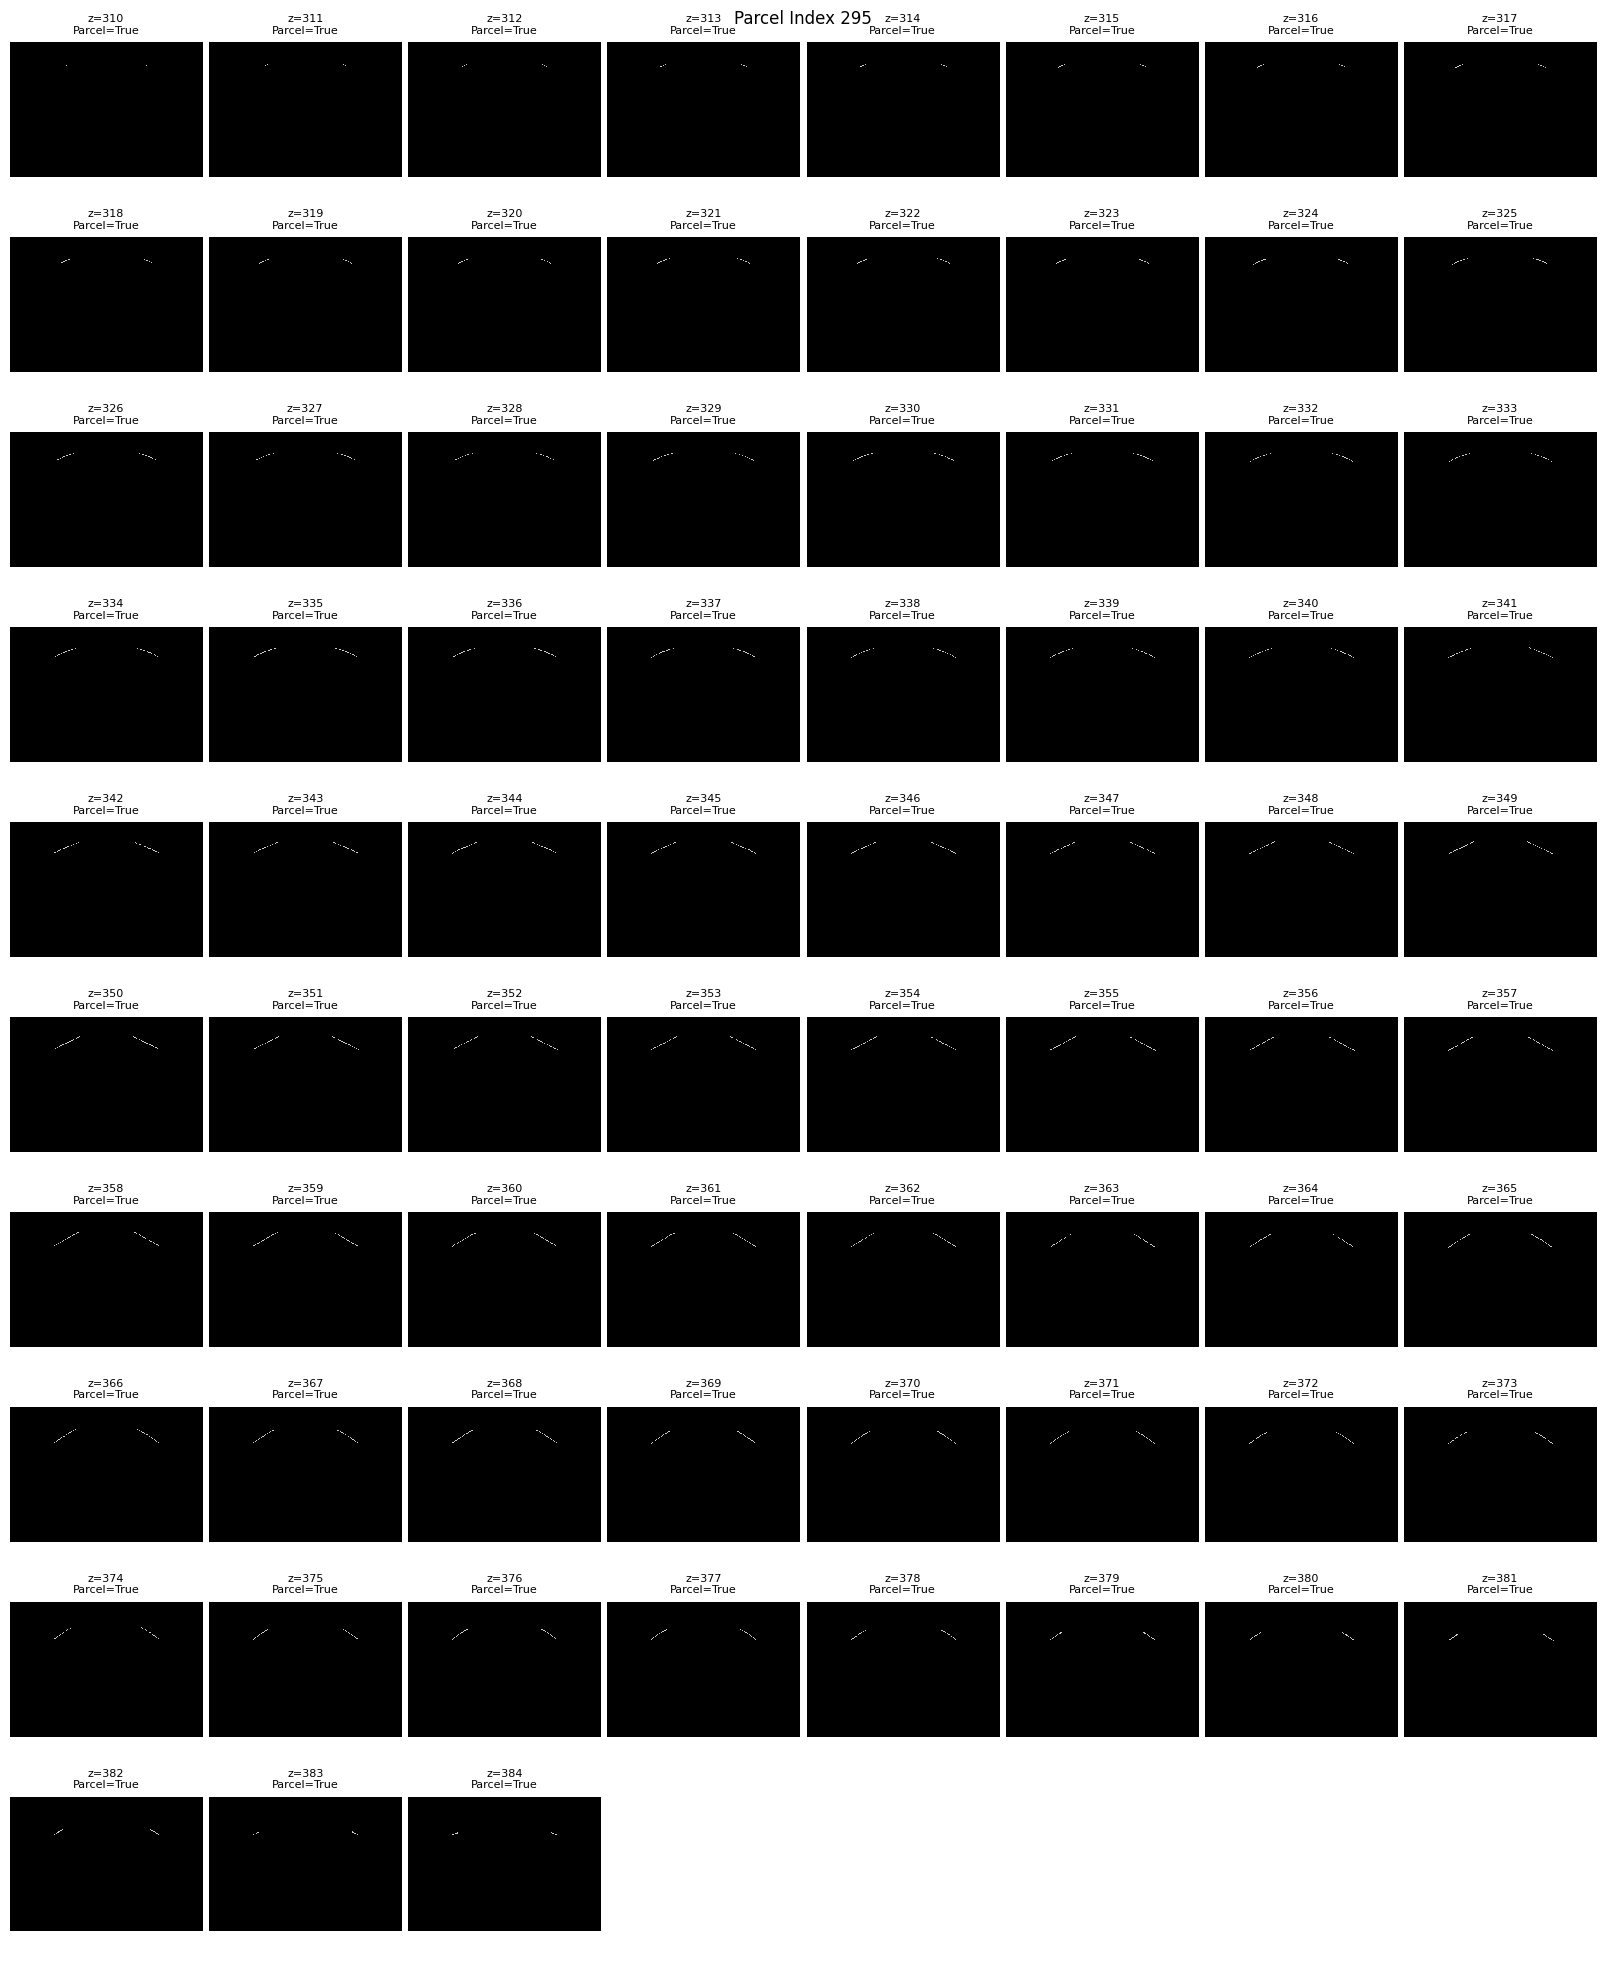

In [10]:
import matplotlib.pyplot as plt
import numpy as np

desired_index = 295
num_slices = annotation_array.shape[2]

# Find slices where parcel is present
valid_slices = [i for i in range(num_slices) if np.any(annotation_array[:, :, i].T == desired_index)]
num_valid_slices = len(valid_slices)

if num_valid_slices == 0:
    print(f"No slices contain Parcel Index {desired_index}")
    plt.close()
else:
    # Set up dynamic grid
    cols = min(8, num_valid_slices)  # Max 8 columns, or fewer if less slices
    rows = int(np.ceil(num_valid_slices / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    if num_valid_slices == 1:
        axes = [axes]  # Handle single subplot case
    else:
        axes = axes.flatten()

    # Plot only valid slices
    for idx, i in enumerate(valid_slices):
        ax = axes[idx]
        zslice = annotation_array[:, :, i].T
        highlighted_slice = np.where(zslice == desired_index, zslice, 0)
        ax.imshow(highlighted_slice, cmap='nipy_spectral', interpolation='none')
        ax.set_title(f'z={i}\nParcel=True', fontsize=8)
        ax.axis('off')

    # Turn off unused axes
    for j in range(num_valid_slices, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Parcel Index {desired_index}', fontsize=12, y=0.98)
    plt.tight_layout(pad=0.5)
    plt.show()